In [1]:
%matplotlib inline

In [2]:
# Data
import pandas as pd
import numpy as np
import re
from collections import Counter
from sklearn import preprocessing
from fancyimpute import MICE

In [3]:
# Visualization
import seaborn as sns
sns.set_style('darkgrid')

In [4]:
import platform
if platform.system() == 'Windows':
    import os
    os.chdir('C:/Users/Lordzsolt/_PythonStuff/Kaggle/Titanic/src')

In [5]:
trainDF = pd.read_csv("../input/train.csv")
testDF = pd.read_csv("../input/test.csv")

# Explore Data

In [6]:
combineDF = pd.concat([trainDF, testDF], axis=0).reset_index(drop=True)
combineDF = combineDF.fillna(np.nan)

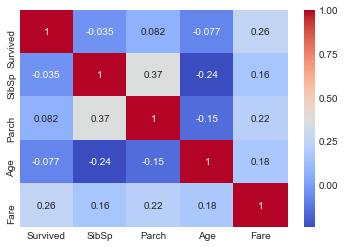

In [7]:
sns.heatmap(combineDF[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, cmap='coolwarm')

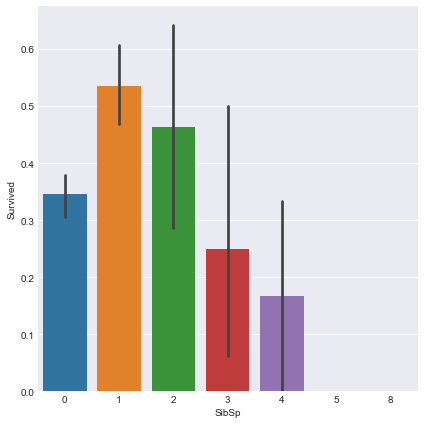

In [8]:
sns.factorplot(x='SibSp', y='Survived', data=combineDF, kind='bar', size=6)

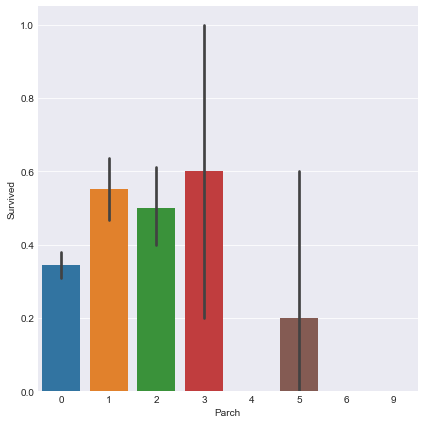

In [9]:
sns.factorplot(x='Parch', y='Survived', data=combineDF, kind='bar', size=6)

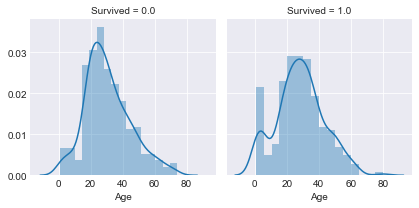

In [10]:
g = sns.FacetGrid(combineDF, col='Survived')
g = g.map(sns.distplot, "Age")

# Handle people with same Ticket

In [11]:
# There are people who share tickets and Fare is the same => That's a group ticket => Fare is skewed
def handle_same_tickets(df):
    duplicates = pd.concat(g for _, g in df.groupby('Ticket') if len(g) > 1)
    duplicates.drop_duplicates(subset=['Ticket'], inplace=True)
    duplicate_tickets = duplicates['Ticket']
    
    ticket_price_map = {}
    for ticket in duplicate_tickets:
        same = df[df['Ticket'] == ticket]
        distinct_fares = same.drop_duplicates(subset=['Fare'])
        if len(distinct_fares) > 1:
            # For some reason there's one group, with Ticket = 7534 who have distinct Fare values, skip that
            continue
        group_size = len(same)
        ticket_price_map[ticket] = same.iloc[1]['Fare'] / group_size
        
        
    return df.apply(lambda x: ticket_price_map[x['Ticket']] if x['Ticket'] in ticket_price_map.keys() else x['Fare'], axis=1)

combineDF['Fare'] = handle_same_tickets(combineDF)

# Check and drop outliers

In [12]:
def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # outlier step
        outlier_step = 1.5 * IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index

        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
# Outliers_to_drop = detect_outliers(trainDF, 2, ['Age', 'SibSp', 'Parch', 'Fare'])
# trainDF.loc[Outliers_to_drop]
# 
# trainDF = trainDF.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

# Handle missing Fares

In [13]:
combineDF[combineDF['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [14]:
people = combineDF[(combineDF['Embarked'] == 'S') & (combineDF['Pclass'] == 3)]
combineDF.loc[combineDF['PassengerId'] == 1044, 'Fare'] = people['Fare'].median()

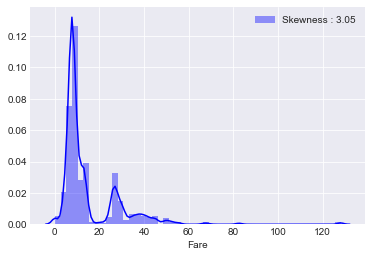

In [21]:
fares = combineDF['Fare']
g = sns.distplot(fares, color='b', label="Skewness : %.2f"%(fares.skew()))
g = g.legend(loc='best')

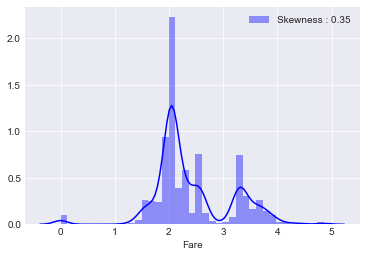

In [22]:
combineDF['Fare'] = combineDF['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

fares = combineDF['Fare']
g = sns.distplot(fares, color='b', label="Skewness : %.2f"%(fares.skew()))
g = g.legend(loc='best')

# Handle missing Embarked

In [27]:
combineDF[combineDF['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,3.688879,"Icard, Miss. Amelie",0,62,1,1,0,1.0,113572
829,62.0,B28,NaN,3.688879,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,1,0,1.0,113572


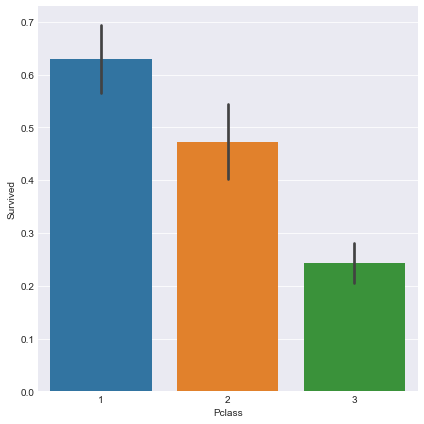

In [23]:
sns.factorplot(x='Pclass', y='Survived', data=combineDF, kind="bar", size=6)

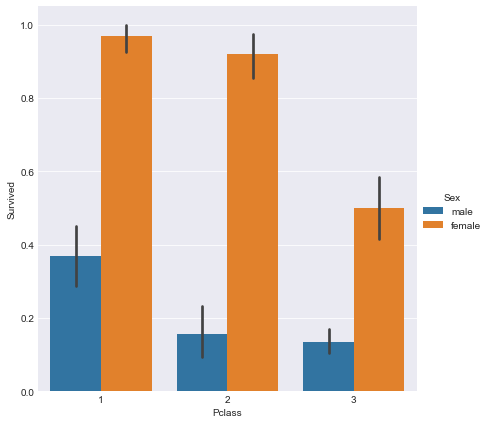

In [24]:
sns.factorplot(x='Pclass', y='Survived', hue='Sex', data=combineDF, kind="bar", size=6)

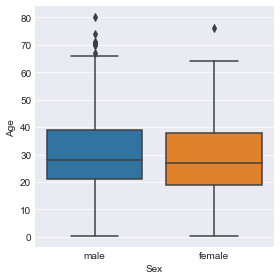

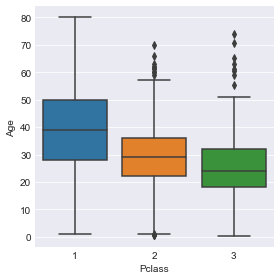

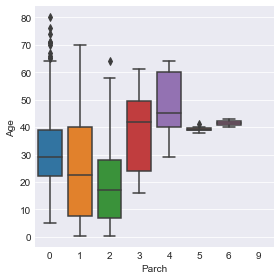

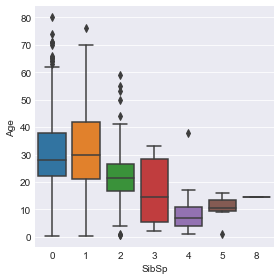

In [25]:
g = sns.factorplot(y='Age', x='Sex', data=combineDF, kind="box")
g = sns.factorplot(y='Age', x='Pclass', data=combineDF, kind="box")
g = sns.factorplot(y='Age', x='Parch', data=combineDF, kind="box")
g = sns.factorplot(y='Age', x='SibSp', data=combineDF, kind="box")

# Transform data

In [26]:
combineDF['Sex'] = combineDF['Sex'].map({'male': 0, 'female': 1})
combineDF.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,1.981001,"Braund, Mr. Owen Harris",0,1,3,0,1,0.0,A/5 21171
1,38.0,C85,C,3.573515,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1.0,PC 17599
2,26.0,NaN,S,2.070022,"Heikkinen, Miss. Laina",0,3,3,1,0,1.0,STON/O2. 3101282
3,35.0,C123,S,3.279030,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.0,113803
4,35.0,NaN,S,2.085672,"Allen, Mr. William Henry",0,5,3,0,0,0.0,373450


# Explore and fill missing Age values

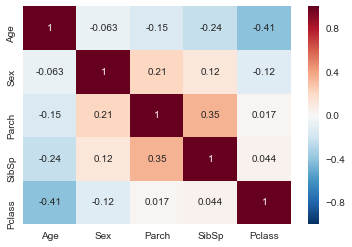

In [125]:
sns.heatmap(combineDF[['Age', 'Sex', 'Parch', 'SibSp', 'Pclass']].corr(), annot=True)

In [126]:
# # Pclass, SibSp, Parch
# pclasses = set(combineDF['Pclass'])
# sibsps = set(combineDF['SibSp'])
# parchs = set(combineDF['Parch'])
# 
# median = combineDF['Age'].median()
# 
# groupMedian = {}
# 
# for pclass in pclasses:
#     groupMedian[pclass] = {}
#     for sibsp in sibsps:
#         groupMedian[pclass][sibsp] = {}
#         for parch in parchs:
#             currentMedian = combineDF['Age'][((combineDF['Pclass'] == pclass) & (combineDF['SibSp'] == sibsp) & (combineDF['Parch'] == parch))].median()
#             if not np.isnan(currentMedian):
#                 groupMedian[pclass][sibsp][parch] = currentMedian
#             else:
#                 groupMedian[pclass][sibsp][parch] = median
#             
# missingAges = list(combineDF['Age'][combineDF['Age'].isnull()].index)
# for index in missingAges:
#     combineDF.loc[index, 'Age'] = groupMedian[combineDF['Pclass'][index]][combineDF['SibSp'][index]][combineDF['Parch'][index]]

In [127]:
features = combineDF.copy()
features.drop(labels=['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
features = pd.get_dummies(features, columns=['Embarked'])
features.head()

,Age,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Embarked_C,Embarked_Q,Embarked_S
0,22.0,1.981001,0,1,3,0,1,0.0,0,0,1
1,38.0,4.266662,0,2,1,1,1,1.0,1,0,0
2,26.0,2.070022,0,3,3,1,0,1.0,0,0,1
3,35.0,3.972177,0,4,1,1,1,1.0,0,0,1
4,35.0,2.085672,0,5,3,0,0,0.0,0,0,1


In [143]:
filled = MICE().complete(np.array(features))

[MICE] Completing matrix with shape (1299, 11)
[MICE] Starting imputation round 1/110, elapsed time 0.001
[MICE] Starting imputation round 2/110, elapsed time 0.004
[MICE] Starting imputation round 3/110, elapsed time 0.006
[MICE] Starting imputation round 4/110, elapsed time 0.008
[MICE] Starting imputation round 5/110, elapsed time 0.009
[MICE] Starting imputation round 6/110, elapsed time 0.010
[MICE] Starting imputation round 7/110, elapsed time 0.011
[MICE] Starting imputation round 8/110, elapsed time 0.011
[MICE] Starting imputation round 9/110, elapsed time 0.012
[MICE] Starting imputation round 10/110, elapsed time 0.012
[MICE] Starting imputation round 11/110, elapsed time 0.013
[MICE] Starting imputation round 12/110, elapsed time 0.014
[MICE] Starting imputation round 13/110, elapsed time 0.014
[MICE] Starting imputation round 14/110, elapsed time 0.015
[MICE] Starting imputation round 15/110, elapsed time 0.016
[MICE] Starting imputation round 16/110, elapsed time 0.017
[M

In [144]:
features.head()

,Age,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Embarked_C,Embarked_Q,Embarked_S
0,22.0,1.981001,0,1,3,0,1,0.0,0,0,1
1,38.0,4.266662,0,2,1,1,1,1.0,1,0,0
2,26.0,2.070022,0,3,3,1,0,1.0,0,0,1
3,35.0,3.972177,0,4,1,1,1,1.0,0,0,1
4,35.0,2.085672,0,5,3,0,0,0.0,0,0,1


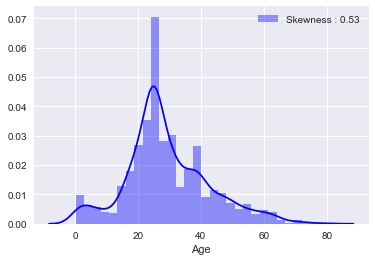

In [145]:
ages = features['Age']
g = sns.distplot(ages, color='b', label="Skewness : %.2f"%(ages.skew()))
g = g.legend(loc='best')

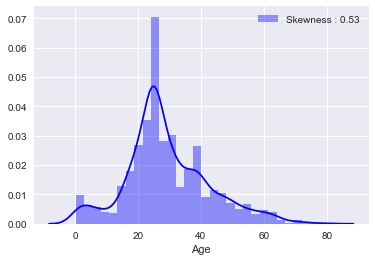

In [151]:
cols = list(features)
results = pd.DataFrame(filled, columns=cols)
ages = results['Age']
g = sns.distplot(ages, color='b', label="Skewness : %.2f"%(ages.skew()))
g = g.legend(loc='best')

In [130]:
# def group_age(x): 
#     if x <= 8:
#         return "Child"
#     elif x <= 18:
#         return "Teen"
#     elif x <= 40:
#         return "Mid"
#     elif x <= 60:
#         return "Late"
#     else:
#         return "Elderly"
# 
# combineDF['AgeGroup'] = list(map(group_age, combineDF['Age']))

# Extract title from name and explore

In [131]:
r = re.compile('(\w*)(\.)')
titles = list(map(lambda x: r.search(x).group(1), combineDF['Name']))

c = Counter(titles)
c.items()

dict_items([('Mr', 753), ('Mrs', 197), ('Miss', 255), ('Master', 60), ('Don', 1), ('Rev', 8), ('Dr', 8), ('Mme', 1), ('Ms', 2), ('Major', 2), ('Lady', 1), ('Sir', 1), ('Mlle', 2), ('Col', 4), ('Capt', 1), ('Countess', 1), ('Jonkheer', 1), ('Dona', 1)])

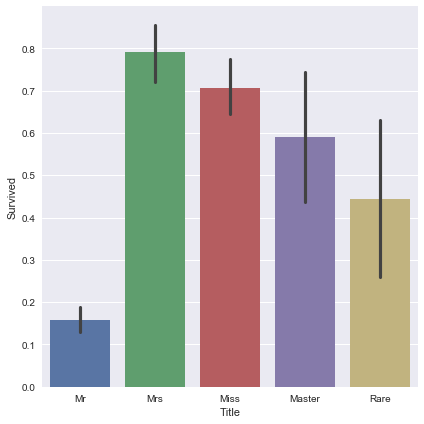

In [132]:
titles = list(map(lambda x: x if c[x] > 10 else 'Rare', titles))
combineDF['Title'] = titles
sns.factorplot(x='Title', y='Survived', data=combineDF, kind="bar", size=6)

In [133]:
combineDF.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,1.981001,"Braund, Mr. Owen Harris",0,1,3,0,1,0.0,A/5 21171,Mr
1,38.0,C85,C,4.266662,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,2.070022,"Heikkinen, Miss. Laina",0,3,3,1,0,1.0,STON/O2. 3101282,Miss
3,35.0,C123,S,3.972177,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.0,113803,Mrs
4,35.0,NaN,S,2.085672,"Allen, Mr. William Henry",0,5,3,0,0,0.0,373450,Mr


# Explore Family Size

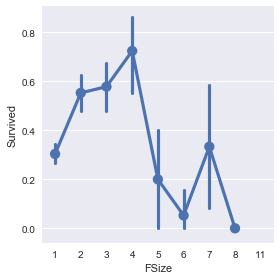

In [134]:
combineDF['FSize'] = combineDF['SibSp'] + combineDF['Parch'] + 1
sns.factorplot(x='FSize', y='Survived', data=combineDF)

In [135]:
def group_fsize(x): 
    if x == 1:
        return "Alone"
    elif x <= 4:
        return "Small"
    else:
        return "Large"

combineDF['FGroup'] = list(map(group_fsize, combineDF['FSize']))

# Explore Cabin

In [136]:
combineDF['Cabin'] = combineDF['Cabin'].fillna('X')
combineDF['Cabin'] = list(map(lambda x: x[0], combineDF['Cabin']))

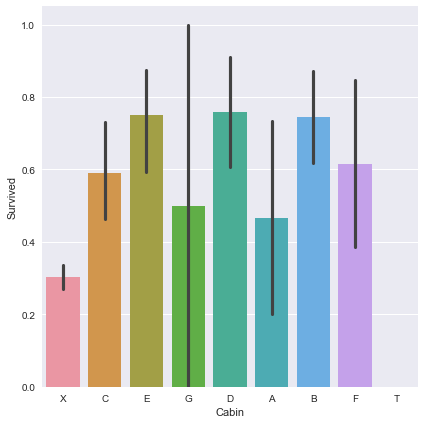

In [137]:
sns.factorplot(x='Cabin', y='Survived', data=combineDF, kind="bar", size=6)

# Explore Ticket

In [138]:
Ticket = []
for i in list(combineDF.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace(".", "").replace("/", "").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
combineDF["Ticket"] = Ticket
combineDF["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

# Drop unused fiels

In [139]:
combineDF.drop(labels=['Name'], axis=1, inplace=True)
combineDF.head()

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,FSize,FGroup
0,22.0,X,S,1.981001,0,1,3,0,1,0.0,A5,Mr,2,Small
1,38.0,C,C,4.266662,0,2,1,1,1,1.0,PC,Mrs,2,Small
2,26.0,X,S,2.070022,0,3,3,1,0,1.0,STONO2,Miss,1,Alone
3,35.0,C,S,3.972177,0,4,1,1,1,1.0,X,Mrs,2,Small
4,35.0,X,S,2.085672,0,5,3,0,0,0.0,X,Mr,1,Alone


# Create dummy variables

In [140]:
combineDF = pd.get_dummies(combineDF, columns=['Cabin'])
combineDF = pd.get_dummies(combineDF, columns=['Embarked'])
combineDF = pd.get_dummies(combineDF, columns=['Title'])
combineDF = pd.get_dummies(combineDF, columns=['FGroup'])
combineDF = pd.get_dummies(combineDF, columns=['Pclass'])
combineDF = pd.get_dummies(combineDF, columns=['Ticket'])
combineDF.head()

,Age,Fare,Parch,PassengerId,Sex,SibSp,Survived,FSize,Cabin_A,Cabin_B,...,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_X
0,22.0,1.981001,0,1,0,1,0.0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,38.0,4.266662,0,2,1,1,1.0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2,26.0,2.070022,0,3,1,0,1.0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,35.0,3.972177,0,4,1,1,1.0,2,0,0,...,0,0,0,0,0,0,0,0,0,1
4,35.0,2.085672,0,5,0,0,0.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


# Feature Scaling

In [141]:
train = combineDF[:train_len].copy()
test = combineDF[train_len:].copy()

labels = ['Age', 'Fare', 'Parch', 'SibSp', 'FSize']
scaler = preprocessing.StandardScaler().fit(train[labels])
train[labels] = scaler.transform(train[labels])
test[labels] = scaler.transform(test[labels])

# Save modified data

In [142]:
test.drop(labels=['Survived'], axis=1, inplace=True)

train.to_csv('../output/train.csv', index=False)
test.to_csv('../output/test.csv', index=False)